#### 이전 코드

In [ ]:
# 사용자 행동 인식 데이터 세트로 결정 트리 실습
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 피처 데이터 로딩
%cd '/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드'
feature_name_df = pd.read_csv('human_activity/features.txt', sep='\s+',header=None,names=['column_index','column_name'])

# 피처명 인덱스 제거, 피쳐명만 리스트 객체로 생성
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출 : ', feature_name[:10])

/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드
전체 피처명에서 10개만 추출 :  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [ ]:
# 중복된 피처명 처리
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [ ]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis = 1)
  new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
  return new_feature_name_df

In [ ]:
# 각 데이터 파일을 로드하는 함수 생성
def get_human_dataset():
  feature_name_df = pd.read_csv('human_activity/features.txt', sep='\s+',header=None,names=['column_index','column_name'])
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()
  X_train = pd.read_csv('human_activity/train/X_train.txt',sep='\s+',names=feature_name)
  X_test = pd.read_csv('human_activity/test/X_test.txt',sep='\s+',names=feature_name)
  y_train = pd.read_csv('human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
  y_test = pd.read_csv('human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

#### GBM

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위해 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {0:.1f}초'.format(time.time()-start_time))

KeyboardInterrupt: ignored

#### XGBoost

In [ ]:
!pip install -q xgboost==0.4a30
import xgboost

     |████████████████████████████████| 753 kB 15.4 MB/s 


In [ ]:
# 파이썬 래퍼 XGBoost
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
# 악성 malignant = 0, 양성 benign = 1, 레이블 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 학습용, 검증용, 테스트용 분할
# feature용 Label용 객체 추출
# 맨 마지막 칼럼 Label 슬라이싱 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [ ]:
# DataFrame 기반 데이터셋을 DMatrix로 변환
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
# 하이퍼 파라미터 딕셔너리 형태로 입력
params = {'max_depth':3, 'eta':0.05, 'objective':'binary:logistic','eval_metric':'logloss'}
num_rounds = 400
# 트리 최대 깊이 3, 학습률 0.5, 목적합수는 이진 로지스틱, 오류 함수는 logloss, 부스팅 반복 횟수는 400

In [ ]:
# 학습 데이터셋 : train, 평가 데이터셋 : eval
eval_list = [(dtr, 'train'),(dval,'eval')]

xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round=num_rounds, early_stopping_rounds = 50, evals=eval_list)

# 반복 시마다 train_logloss와 eval_logloss가 지속적으로 감소

Will train until eval error hasn't decreased in 50 rounds.
[0]	train-logloss:0.650163	eval-logloss:0.661831
[1]	train-logloss:0.611313	eval-logloss:0.636086
[2]	train-logloss:0.575629	eval-logloss:0.611436
[3]	train-logloss:0.543102	eval-logloss:0.592036
[4]	train-logloss:0.513233	eval-logloss:0.573291
[5]	train-logloss:0.484475	eval-logloss:0.550371
[6]	train-logloss:0.457959	eval-logloss:0.529295
[7]	train-logloss:0.434357	eval-logloss:0.515340
[8]	train-logloss:0.411503	eval-logloss:0.497179
[9]	train-logloss:0.390274	eval-logloss:0.481542
[10]	train-logloss:0.371284	eval-logloss:0.469904
[11]	train-logloss:0.352541	eval-logloss:0.454740
[12]	train-logloss:0.335277	eval-logloss:0.442294
[13]	train-logloss:0.318925	eval-logloss:0.429608
[14]	train-logloss:0.304394	eval-logloss:0.420650
[15]	train-logloss:0.289996	eval-logloss:0.409577
[16]	train-logloss:0.276514	eval-logloss:0.398867
[17]	train-logloss:0.263894	eval-logloss:0.390504
[18]	train-logloss:0.252102	eval-logloss:0.382539
[

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 : ',preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.851 0.009 0.674 0.084 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


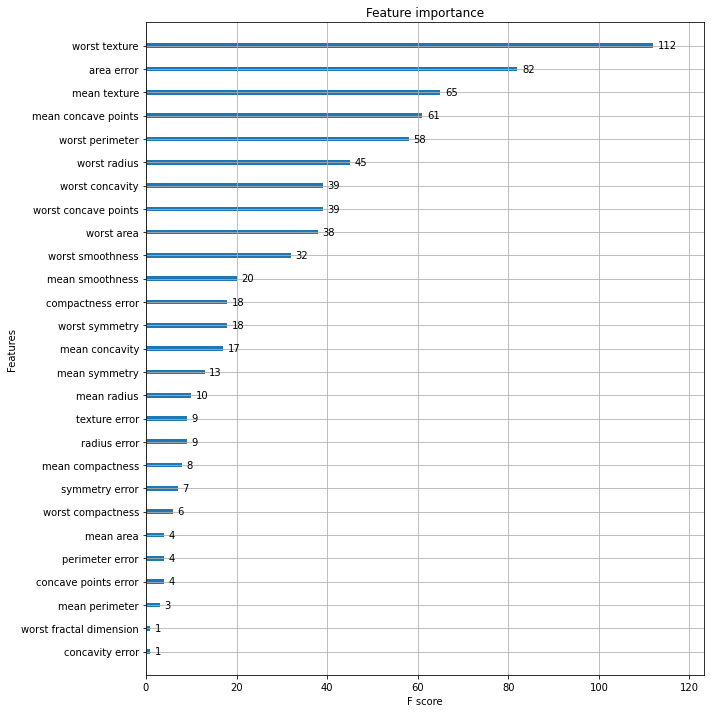

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

In [ ]:
# 사이킷런 래퍼 XGBoost
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9954


In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',eval_set=evals, verbose=True)
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-logloss:0.650163	validation_1-logloss:0.661831
[1]	validation_0-logloss:0.611313	validation_1-logloss:0.636086
[2]	validation_0-logloss:0.575629	validation_1-logloss:0.611436
[3]	validation_0-logloss:0.543102	validation_1-logloss:0.592036
[4]	validation_0-logloss:0.513233	validation_1-logloss:0.573291
[5]	validation_0-logloss:0.484475	validation_1-logloss:0.550371
[6]	validation_0-logloss:0.457959	validation_1-logloss:0.529295
[7]	validation_0-logloss:0.434357	validation_1-logloss:0.515340
[8]	validation_0-logloss:0.411503	validation_1-logloss:0.497179
[9]	validation_0-logloss:0.390274	validation_1-logloss:0.481542
[10]	validation_0-logloss:0.371284	validation_1-logloss:0.469904
[11]	validation_0-logloss:0.352541	validation_1-logloss:0.454740
[12]	validation_0-logloss:0.335277	validation_1-logloss:0.442294
[13]	validation_0-logloss:0.318925	validation_1-logloss:0.429608
[14]	validation_0-logloss:0.30439

In [ ]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


In [ ]:
# 조기 중단 반복 횟수를 10으로 하고 재학습 -> 성능 저하
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss',eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


Will train until validation_1 error hasn't decreased in 10 rounds.
[0]	validation_0-logloss:0.650163	validation_1-logloss:0.661831
[1]	validation_0-logloss:0.611313	validation_1-logloss:0.636086
[2]	validation_0-logloss:0.575629	validation_1-logloss:0.611436
[3]	validation_0-logloss:0.543102	validation_1-logloss:0.592036
[4]	validation_0-logloss:0.513233	validation_1-logloss:0.573291
[5]	validation_0-logloss:0.484475	validation_1-logloss:0.550371
[6]	validation_0-logloss:0.457959	validation_1-logloss:0.529295
[7]	validation_0-logloss:0.434357	validation_1-logloss:0.515340
[8]	validation_0-logloss:0.411503	validation_1-logloss:0.497179
[9]	validation_0-logloss:0.390274	validation_1-logloss:0.481542
[10]	validation_0-logloss:0.371284	validation_1-logloss:0.469904
[11]	validation_0-logloss:0.352541	validation_1-logloss:0.454740
[12]	validation_0-logloss:0.335277	validation_1-logloss:0.442294
[13]	validation_0-logloss:0.318925	validation_1-logloss:0.429608
[14]	validation_0-logloss:0.30439

#### LightGBM

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier

dataset = load_breast_cancer()
cancer_df = pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state =156)

lgbm_wrap = LGBMClassifier(n_estimators = 400, learning_rate=0.05)

evals = [(X_tr, y_tr),(X_val,y_val)]
lgbm_wrap.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrap.predict(X_test)
pred_proba = lgbm_wrap.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248	valid_1's binary_logloss: 0.628248
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.588173	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	training's binary_loglos

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9888


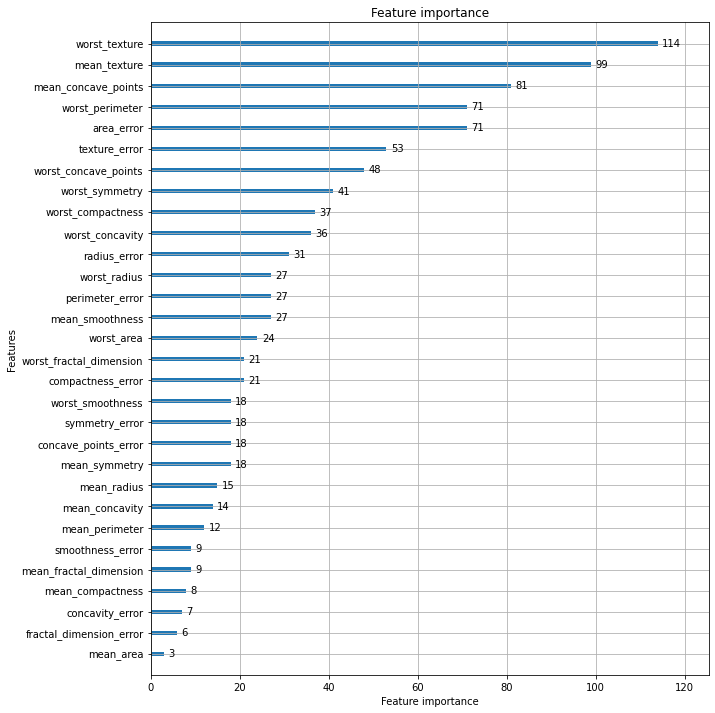

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrap, ax=ax)

#### 베이지안 최적화 기반 HyperOpt를 이용한 하이퍼 파라미터 튜닝

In [ ]:
# HyperOpt 사용
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hyperopt import hp
search_space = {'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [ ]:
from hyperopt import STATUS_OK
def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x**2 - 20*y
  return retval

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, Trials
trial_val = Trials()
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,trials=trial_val)
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 263.69it/s, best loss: -256.0]
best: {'x': -2.0, 'y': 13.0}


In [ ]:
trial_val = Trials()
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,trials=trial_val)
print('best:', best_01)

100%|██████████| 20/20 [00:00<00:00, 300.44it/s, best loss: -280.0]
best: {'x': -2.0, 'y': 13.0}


In [ ]:
print(trial_val.results)

[{'loss': 241.0, 'status': 'ok'}, {'loss': 104.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': -236.0, 'status': 'ok'}, {'loss': 156.0, 'status': 'ok'}, {'loss': -156.0, 'status': 'ok'}, {'loss': 269.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': 101.0, 'status': 'ok'}, {'loss': -216.0, 'status': 'ok'}, {'loss': 89.0, 'status': 'ok'}, {'loss': 161.0, 'status': 'ok'}, {'loss': 80.0, 'status': 'ok'}, {'loss': -124.0, 'status': 'ok'}, {'loss': -76.0, 'status': 'ok'}, {'loss': 261.0, 'status': 'ok'}, {'loss': 360.0, 'status': 'ok'}, {'loss': -24.0, 'status': 'ok'}, {'loss': -280.0, 'status': 'ok'}]


In [ ]:
print(trial_val.vals)

{'x': [-1.0, 2.0, -9.0, 2.0, -6.0, 8.0, -7.0, 6.0, 4.0, -1.0, -2.0, 3.0, 9.0, 0.0, -6.0, -2.0, 1.0, 10.0, 4.0, -0.0], 'y': [-12.0, -5.0, 6.0, 12.0, -6.0, 11.0, -11.0, 11.0, -8.0, -5.0, 11.0, -4.0, -4.0, -4.0, 8.0, 4.0, -13.0, -13.0, 2.0, 14.0]}


In [ ]:
import pandas as pd
losses = [loss_dict['loss'] for loss_dict in trial_val.results]
result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-1.0,-12.0,241.0
1,2.0,-5.0,104.0
2,-9.0,6.0,-39.0
3,2.0,12.0,-236.0
4,-6.0,-6.0,156.0
5,8.0,11.0,-156.0
6,-7.0,-11.0,269.0
7,6.0,11.0,-184.0
8,4.0,-8.0,176.0
9,-1.0,-5.0,101.0


In [ ]:
# 위스콘신 유방암 데이터셋 실습
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
#from hyperopt import fmin, tpe, Trials

#trial_val = Trials()
#best = fmin(fn=objective_func,
#            space=xgb_search_space,
#            algo=tpe.suggest,
#            max_evals=50, trials=trial_val)
#print('best:', best)

#### 분류 실습 - 캐글 산탄데르 고객 만족 예측

In [3]:
#데이터 전처리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
%cd '/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드'
cust_df = pd.read_csv('train.csv', encoding='latin-1')
print('dataset shape : ', cust_df.shape)
cust_df.head(3)

/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드
dataset shape :  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
# var3 칼럼 최소값이 -999999 : 2로 변환
# ID 피처는 드롭
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape : {0}'.format(X_features.shape))

피처 데이터 shape : (76020, 369)


In [8]:
# 학습 데이터셋와 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape:{0}, 테스트 세트 shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape:(60816, 369), 테스트 세트 shape:(15204, 369)
학습 세트 레이블값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [9]:
# 검증 데이터 세트 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
# XGBoost 학습 모델 생성
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05)
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

Will train until validation_1 error hasn't decreased in 100 rounds.
[0]	validation_0-auc:0.803388	validation_1-auc:0.797852
[1]	validation_0-auc:0.812619	validation_1-auc:0.796774
[2]	validation_0-auc:0.811648	validation_1-auc:0.798697
[3]	validation_0-auc:0.812568	validation_1-auc:0.797626
[4]	validation_0-auc:0.814884	validation_1-auc:0.798837
[5]	validation_0-auc:0.814676	validation_1-auc:0.800850
[6]	validation_0-auc:0.814879	validation_1-auc:0.799201
[7]	validation_0-auc:0.815144	validation_1-auc:0.798952
[8]	validation_0-auc:0.816290	validation_1-auc:0.801921
[9]	validation_0-auc:0.816236	validation_1-auc:0.800339
[10]	validation_0-auc:0.815842	validation_1-auc:0.801910
[11]	validation_0-auc:0.816102	validation_1-auc:0.800052
[12]	validation_0-auc:0.818573	validation_1-auc:0.805199
[13]	validation_0-auc:0.816937	validation_1-auc:0.801944
[14]	validation_0-auc:0.816405	validation_1-auc:0.801992
[15]	validation_0-auc:0.819057	validation_1-auc:0.805292
[16]	validation_0-auc:0.819138

ROC AUC : 0.8413


In [ ]:
# HyperOpt 하이퍼 파라미터 검색 공간 설정
from hyperopt import hp
xgb_search_space = {'max_depth': hp.quniform('max_depth',5,15,1),
                    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                    'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95),
                    'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [ ]:
# 목적 함수 생성
# 3Fold 교차 검증, 평균 ROC-AUC 값에 -1 곱하여 반환하도록
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list= []
    
  # 3개 k-fold방식 적용 
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
    # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
  return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

print('best:', best)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.813616	validation_1-auc:0.781736

[1]	validation_0-auc:0.791710	validation_1-auc:0.744596

[2]	validation_0-auc:0.791874	validation_1-auc:0.744783

[3]	validation_0-auc:0.813965	validation_1-auc:0.760687

[4]	validation_0-auc:0.836301	validation_1-auc:0.778131

[5]	validation_0-auc:0.829388	validation_1-auc:0.766587

[6]	validation_0-auc:0.841491	validation_1-auc:0.774706

[7]	validation_0-auc:0.851742	validation_1-auc:0.783902

[8]	validation_0-auc:0.858977	validation_1-auc:0.789790

[9]	validation_0-auc:0.866813	validation_1-auc:0.794458

[10]	validation_0-auc:0.873618	validation_1-auc:0.798381

[11]	validation_0-auc:0.879097	validation_1-auc:0.798566

[12]	validation_0-auc:0.884349	validation_1-auc:0.801730

[13]	validation_0-auc:0.888467	validation_1-auc:0.805298

[14]	validation_0-auc:0.892723	validation_1-auc:0.807528

[15]	validation_0-auc:0.893332	validation_1-auc:0.808648

[16]	validatio

  2%|▏         | 1/50 [02:09<1:45:39, 129.39s/it, best loss: -0.8223301948064012]

[74]	validation_0-auc:0.960453	validation_1-auc:0.821977

Stopping. Best iteration:
[44]	validation_0-auc:0.950746	validation_1-auc:0.826697


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.807427	validation_1-auc:0.781964

[1]	validation_0-auc:0.774964	validation_1-auc:0.737475

[2]	validation_0-auc:0.774403	validation_1-auc:0.740606

[3]	validation_0-auc:0.790087	validation_1-auc:0.750201

[4]	validation_0-auc:0.807884	validation_1-auc:0.768944

[5]	validation_0-auc:0.796590	validation_1-auc:0.756850

[6]	validation_0-auc:0.799448	validation_1-auc:0.759973

[7]	validation_0-auc:0.805100	validation_1-auc:0.767379

[8]	validation_0-auc:0.804823	validation_1-auc:0.769056

[9]	validation_0-auc:0.811165	validation_1-auc:0.774434

[10]	validation_0-auc:0.816616	validation_1-auc:0.779224

[11]	validation_0-auc:0.814700	validation_1-auc:0.774535

[12]	validation_0-auc:0.819241	validation_1-auc:0.778591

[13]	validation_0-auc:0.819274	validation_1-a

  4%|▍         | 2/50 [04:04<1:36:55, 121.16s/it, best loss: -0.8305672536467338]

[99]	validation_0-auc:0.928533	validation_1-auc:0.831149

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.789904	validation_1-auc:0.768023

[1]	validation_0-auc:0.786096	validation_1-auc:0.757339

[2]	validation_0-auc:0.777675	validation_1-auc:0.751234

[3]	validation_0-auc:0.777867	validation_1-auc:0.752237

[4]	validation_0-auc:0.799279	validation_1-auc:0.769451

[5]	validation_0-auc:0.801521	validation_1-auc:0.769922

[6]	validation_0-auc:0.806602	validation_1-auc:0.775420

[7]	validation_0-auc:0.809622	validation_1-auc:0.777881

[8]	validation_0-auc:0.812304	validation_1-auc:0.780441

[9]	validation_0-auc:0.817455	validation_1-auc:0.785853

[10]	validation_0-auc:0.823646	validation_1-auc:0.792426

[11]	validation_0-auc:0.825555	validation_1-auc:0.795503

[12]	validation_0-auc:0.830068	validation_1-auc:0.799163

[13]	validation_0-auc:0.833324	validation_1-auc:0.801136

[14]	validation_0-auc:0.839205	validation_1-auc:0.806470

[15]	validatio

  6%|▌         | 3/50 [04:49<1:07:42, 86.43s/it, best loss: -0.8334348943130002] 

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.791366	validation_1-auc:0.767469

[1]	validation_0-auc:0.789107	validation_1-auc:0.758824

[2]	validation_0-auc:0.779433	validation_1-auc:0.752149

[3]	validation_0-auc:0.779586	validation_1-auc:0.756209

[4]	validation_0-auc:0.784244	validation_1-auc:0.763711

[5]	validation_0-auc:0.785611	validation_1-auc:0.765031

[6]	validation_0-auc:0.792394	validation_1-auc:0.770741

[7]	validation_0-auc:0.800395	validation_1-auc:0.776830

[8]	validation_0-auc:0.804168	validation_1-auc:0.779942

[9]	validation_0-auc:0.807192	validation_1-auc:0.783184

[10]	validation_0-auc:0.809964	validation_1-auc:0.786089

[11]	validation_0-auc:0.808633	validation_1-auc:0.784652

[12]	validation_0-auc:0.810845	validation_1-auc:0.785806

[13]	validation_0-auc:0.812951	validation_1-auc:0.787777

[14]	validation_0-auc:0.816462	validation_1-auc:0.790097

[15]	validation_0-auc:0.815688	validation_1-auc:0.788836

[16]	validatio

  8%|▊         | 4/50 [05:44<56:36, 73.83s/it, best loss: -0.8378892035505895]  

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.800072	validation_1-auc:0.774663

[1]	validation_0-auc:0.767311	validation_1-auc:0.736505

[2]	validation_0-auc:0.769341	validation_1-auc:0.738569

[3]	validation_0-auc:0.792001	validation_1-auc:0.758787

[4]	validation_0-auc:0.815518	validation_1-auc:0.778586

[5]	validation_0-auc:0.802797	validation_1-auc:0.763527

[6]	validation_0-auc:0.822439	validation_1-auc:0.783070

[7]	validation_0-auc:0.830395	validation_1-auc:0.789549

[8]	validation_0-auc:0.836088	validation_1-auc:0.794534

[9]	validation_0-auc:0.841437	validation_1-auc:0.798766

[10]	validation_0-auc:0.845231	validation_1-auc:0.801886

[11]	validation_0-auc:0.846919	validation_1-auc:0.801116

[12]	validation_0-auc:0.850539	validation_1-auc:0.805012

[13]	validation_0-auc:0.851350	validation_1-auc:0.804026

[14]	validation_0-auc:0.855915	validation_1-auc:0.807311

[15]	validation_0-auc:0.858323	validation_1-auc:0.811485

[16]	validatio

 10%|█         | 5/50 [07:02<56:31, 75.36s/it, best loss: -0.8378892035505895]

[89]	validation_0-auc:0.919233	validation_1-auc:0.832437

Stopping. Best iteration:
[59]	validation_0-auc:0.911736	validation_1-auc:0.835322


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.797913	validation_1-auc:0.774646

[1]	validation_0-auc:0.793026	validation_1-auc:0.765348

[2]	validation_0-auc:0.790219	validation_1-auc:0.763103

[3]	validation_0-auc:0.813272	validation_1-auc:0.785620

[4]	validation_0-auc:0.819445	validation_1-auc:0.789440

[5]	validation_0-auc:0.821757	validation_1-auc:0.789778

[6]	validation_0-auc:0.813244	validation_1-auc:0.788695

[7]	validation_0-auc:0.808567	validation_1-auc:0.785746

[8]	validation_0-auc:0.802066	validation_1-auc:0.783853

[9]	validation_0-auc:0.810865	validation_1-auc:0.791772

[10]	validation_0-auc:0.817530	validation_1-auc:0.796347

[11]	validation_0-auc:0.819184	validation_1-auc:0.796511

[12]	validation_0-auc:0.825703	validation_1-auc:0.801759

[13]	validation_0-auc:0.827693	validation_1-a

 12%|█▏        | 6/50 [08:29<58:04, 79.19s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.898604	validation_1-auc:0.839088

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.812704	validation_1-auc:0.783045

[1]	validation_0-auc:0.805348	validation_1-auc:0.767907

[2]	validation_0-auc:0.793615	validation_1-auc:0.760739

[3]	validation_0-auc:0.792897	validation_1-auc:0.759808

[4]	validation_0-auc:0.801857	validation_1-auc:0.770001

[5]	validation_0-auc:0.807444	validation_1-auc:0.772455

[6]	validation_0-auc:0.815280	validation_1-auc:0.778143

[7]	validation_0-auc:0.820140	validation_1-auc:0.780492

[8]	validation_0-auc:0.824277	validation_1-auc:0.783550

[9]	validation_0-auc:0.829336	validation_1-auc:0.785947

[10]	validation_0-auc:0.834072	validation_1-auc:0.788642

[11]	validation_0-auc:0.832831	validation_1-auc:0.787932

[12]	validation_0-auc:0.836269	validation_1-auc:0.790864

[13]	validation_0-auc:0.837556	validation_1-auc:0.791531

[14]	validation_0-auc:0.842014	validation_1-auc:0.793155

[15]	validatio

 14%|█▍        | 7/50 [10:16<1:03:21, 88.40s/it, best loss: -0.8378892035505895]

[71]	validation_0-auc:0.917900	validation_1-auc:0.829194

Stopping. Best iteration:
[41]	validation_0-auc:0.898221	validation_1-auc:0.829994


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.795278	validation_1-auc:0.773063

[1]	validation_0-auc:0.795648	validation_1-auc:0.764447

[2]	validation_0-auc:0.786924	validation_1-auc:0.758579

[3]	validation_0-auc:0.807033	validation_1-auc:0.775143

[4]	validation_0-auc:0.812931	validation_1-auc:0.780372

[5]	validation_0-auc:0.814846	validation_1-auc:0.783285

[6]	validation_0-auc:0.819692	validation_1-auc:0.785807

[7]	validation_0-auc:0.826583	validation_1-auc:0.792974

[8]	validation_0-auc:0.832530	validation_1-auc:0.799601

[9]	validation_0-auc:0.837544	validation_1-auc:0.804322

[10]	validation_0-auc:0.843623	validation_1-auc:0.808394

[11]	validation_0-auc:0.842820	validation_1-auc:0.807775

[12]	validation_0-auc:0.846874	validation_1-auc:0.813308

[13]	validation_0-auc:0.847940	validation_1-a

 16%|█▌        | 8/50 [11:15<55:26, 79.19s/it, best loss: -0.8378892035505895]  

[72]	validation_0-auc:0.900872	validation_1-auc:0.835213

Stopping. Best iteration:
[42]	validation_0-auc:0.888717	validation_1-auc:0.837636


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.811939	validation_1-auc:0.783001

[1]	validation_0-auc:0.811858	validation_1-auc:0.775477

[2]	validation_0-auc:0.811141	validation_1-auc:0.779838

[3]	validation_0-auc:0.827698	validation_1-auc:0.791345

[4]	validation_0-auc:0.835720	validation_1-auc:0.798015

[5]	validation_0-auc:0.833817	validation_1-auc:0.794199

[6]	validation_0-auc:0.828451	validation_1-auc:0.793221

[7]	validation_0-auc:0.832965	validation_1-auc:0.797512

[8]	validation_0-auc:0.831143	validation_1-auc:0.794515

[9]	validation_0-auc:0.836947	validation_1-auc:0.798379

[10]	validation_0-auc:0.839217	validation_1-auc:0.802003

[11]	validation_0-auc:0.841489	validation_1-auc:0.801268

[12]	validation_0-auc:0.843931	validation_1-auc:0.802800

[13]	validation_0-auc:0.847700	validation_1-a

 18%|█▊        | 9/50 [13:40<1:08:01, 99.54s/it, best loss: -0.8378892035505895]

[73]	validation_0-auc:0.920839	validation_1-auc:0.827163

Stopping. Best iteration:
[43]	validation_0-auc:0.899621	validation_1-auc:0.828899


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.813450	validation_1-auc:0.782586

[1]	validation_0-auc:0.802101	validation_1-auc:0.764556

[2]	validation_0-auc:0.791962	validation_1-auc:0.759817

[3]	validation_0-auc:0.776756	validation_1-auc:0.741437

[4]	validation_0-auc:0.785467	validation_1-auc:0.749999

[5]	validation_0-auc:0.770565	validation_1-auc:0.736799

[6]	validation_0-auc:0.781766	validation_1-auc:0.748046

[7]	validation_0-auc:0.786708	validation_1-auc:0.751152

[8]	validation_0-auc:0.787965	validation_1-auc:0.753873

[9]	validation_0-auc:0.792823	validation_1-auc:0.756771

[10]	validation_0-auc:0.797400	validation_1-auc:0.758757

[11]	validation_0-auc:0.795244	validation_1-auc:0.758351

[12]	validation_0-auc:0.799934	validation_1-auc:0.761865

[13]	validation_0-auc:0.803707	validation_1-a

 20%|██        | 10/50 [15:04<1:03:16, 94.91s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.901041	validation_1-auc:0.816958

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.807580	validation_1-auc:0.781349

[1]	validation_0-auc:0.796209	validation_1-auc:0.761989

[2]	validation_0-auc:0.790079	validation_1-auc:0.757619

[3]	validation_0-auc:0.789460	validation_1-auc:0.754713

[4]	validation_0-auc:0.792201	validation_1-auc:0.753432

[5]	validation_0-auc:0.793933	validation_1-auc:0.755205

[6]	validation_0-auc:0.798133	validation_1-auc:0.758172

[7]	validation_0-auc:0.798443	validation_1-auc:0.758852

[8]	validation_0-auc:0.796611	validation_1-auc:0.757651

[9]	validation_0-auc:0.802186	validation_1-auc:0.761880

[10]	validation_0-auc:0.808098	validation_1-auc:0.765571

[11]	validation_0-auc:0.806736	validation_1-auc:0.763708

[12]	validation_0-auc:0.812960	validation_1-auc:0.767818

[13]	validation_0-auc:0.814233	validation_1-auc:0.767593

[14]	validation_0-auc:0.818145	validation_1-auc:0.770695

[15]	validatio

 22%|██▏       | 11/50 [16:56<1:05:01, 100.03s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.939344	validation_1-auc:0.826369

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.799765	validation_1-auc:0.774539

[1]	validation_0-auc:0.794542	validation_1-auc:0.761431

[2]	validation_0-auc:0.783018	validation_1-auc:0.753514

[3]	validation_0-auc:0.784368	validation_1-auc:0.754551

[4]	validation_0-auc:0.790092	validation_1-auc:0.763893

[5]	validation_0-auc:0.780300	validation_1-auc:0.750104

[6]	validation_0-auc:0.798879	validation_1-auc:0.767074

[7]	validation_0-auc:0.808857	validation_1-auc:0.774057

[8]	validation_0-auc:0.812437	validation_1-auc:0.777955

[9]	validation_0-auc:0.816156	validation_1-auc:0.781092

[10]	validation_0-auc:0.820248	validation_1-auc:0.784430

[11]	validation_0-auc:0.819110	validation_1-auc:0.782452

[12]	validation_0-auc:0.823048	validation_1-auc:0.785119

[13]	validation_0-auc:0.826162	validation_1-auc:0.786311

[14]	validation_0-auc:0.830443	validation_1-auc:0.789319

[15]	validatio

 24%|██▍       | 12/50 [18:08<58:00, 91.60s/it, best loss: -0.8378892035505895]   

[99]	validation_0-auc:0.913951	validation_1-auc:0.836337

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.812511	validation_1-auc:0.786922

[1]	validation_0-auc:0.800517	validation_1-auc:0.765006

[2]	validation_0-auc:0.798822	validation_1-auc:0.763292

[3]	validation_0-auc:0.781541	validation_1-auc:0.738459

[4]	validation_0-auc:0.807844	validation_1-auc:0.761145

[5]	validation_0-auc:0.806343	validation_1-auc:0.761388

[6]	validation_0-auc:0.818670	validation_1-auc:0.770191

[7]	validation_0-auc:0.830728	validation_1-auc:0.774324

[8]	validation_0-auc:0.837878	validation_1-auc:0.777784

[9]	validation_0-auc:0.844709	validation_1-auc:0.781643

[10]	validation_0-auc:0.852334	validation_1-auc:0.785530

[11]	validation_0-auc:0.854953	validation_1-auc:0.784624

[12]	validation_0-auc:0.858686	validation_1-auc:0.788431

[13]	validation_0-auc:0.863384	validation_1-auc:0.789884

[14]	validation_0-auc:0.867940	validation_1-auc:0.791517

[15]	validatio

 26%|██▌       | 13/50 [19:40<56:35, 91.76s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.959355	validation_1-auc:0.823143

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.795610	validation_1-auc:0.773086

[1]	validation_0-auc:0.790000	validation_1-auc:0.759670

[2]	validation_0-auc:0.779932	validation_1-auc:0.754974

[3]	validation_0-auc:0.781466	validation_1-auc:0.754193

[4]	validation_0-auc:0.802923	validation_1-auc:0.773897

[5]	validation_0-auc:0.804936	validation_1-auc:0.778526

[6]	validation_0-auc:0.809692	validation_1-auc:0.780955

[7]	validation_0-auc:0.813488	validation_1-auc:0.783776

[8]	validation_0-auc:0.817058	validation_1-auc:0.787274

[9]	validation_0-auc:0.821463	validation_1-auc:0.790986

[10]	validation_0-auc:0.828035	validation_1-auc:0.796777

[11]	validation_0-auc:0.823928	validation_1-auc:0.792391

[12]	validation_0-auc:0.827544	validation_1-auc:0.795117

[13]	validation_0-auc:0.830293	validation_1-auc:0.795868

[14]	validation_0-auc:0.835226	validation_1-auc:0.800857

[15]	validatio

 28%|██▊       | 14/50 [20:44<49:52, 83.13s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.901922	validation_1-auc:0.838671

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.812058	validation_1-auc:0.782052

[1]	validation_0-auc:0.787570	validation_1-auc:0.744197

[2]	validation_0-auc:0.783789	validation_1-auc:0.740495

[3]	validation_0-auc:0.805086	validation_1-auc:0.756995

[4]	validation_0-auc:0.824636	validation_1-auc:0.775781

[5]	validation_0-auc:0.817319	validation_1-auc:0.765767

[6]	validation_0-auc:0.835861	validation_1-auc:0.782343

[7]	validation_0-auc:0.846113	validation_1-auc:0.789998

[8]	validation_0-auc:0.853278	validation_1-auc:0.794021

[9]	validation_0-auc:0.858656	validation_1-auc:0.798118

[10]	validation_0-auc:0.862823	validation_1-auc:0.800437

[11]	validation_0-auc:0.867708	validation_1-auc:0.801474

[12]	validation_0-auc:0.872258	validation_1-auc:0.805385

[13]	validation_0-auc:0.876776	validation_1-auc:0.807715

[14]	validation_0-auc:0.882055	validation_1-auc:0.809096

[15]	validatio

 30%|███       | 15/50 [22:45<55:16, 94.76s/it, best loss: -0.8378892035505895]

[78]	validation_0-auc:0.949457	validation_1-auc:0.826608

Stopping. Best iteration:
[48]	validation_0-auc:0.939733	validation_1-auc:0.828795


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.816190	validation_1-auc:0.785328

[1]	validation_0-auc:0.808409	validation_1-auc:0.770041

[2]	validation_0-auc:0.796291	validation_1-auc:0.761778

[3]	validation_0-auc:0.799281	validation_1-auc:0.765594

[4]	validation_0-auc:0.805594	validation_1-auc:0.769334

[5]	validation_0-auc:0.809155	validation_1-auc:0.771047

[6]	validation_0-auc:0.817232	validation_1-auc:0.775589

[7]	validation_0-auc:0.829678	validation_1-auc:0.781794

[8]	validation_0-auc:0.839242	validation_1-auc:0.786712

[9]	validation_0-auc:0.846582	validation_1-auc:0.791052

[10]	validation_0-auc:0.854747	validation_1-auc:0.793784

[11]	validation_0-auc:0.857522	validation_1-auc:0.791795

[12]	validation_0-auc:0.862074	validation_1-auc:0.795490

[13]	validation_0-auc:0.866246	validation_1-a

 32%|███▏      | 16/50 [25:06<1:01:36, 108.73s/it, best loss: -0.8378892035505895]

[71]	validation_0-auc:0.947577	validation_1-auc:0.822893

Stopping. Best iteration:
[41]	validation_0-auc:0.932264	validation_1-auc:0.825710


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.807427	validation_1-auc:0.781964

[1]	validation_0-auc:0.775050	validation_1-auc:0.737538

[2]	validation_0-auc:0.774791	validation_1-auc:0.738776

[3]	validation_0-auc:0.789616	validation_1-auc:0.748253

[4]	validation_0-auc:0.813009	validation_1-auc:0.769928

[5]	validation_0-auc:0.802072	validation_1-auc:0.756481

[6]	validation_0-auc:0.807709	validation_1-auc:0.764010

[7]	validation_0-auc:0.810397	validation_1-auc:0.768622

[8]	validation_0-auc:0.808871	validation_1-auc:0.769487

[9]	validation_0-auc:0.817518	validation_1-auc:0.776723

[10]	validation_0-auc:0.824700	validation_1-auc:0.782565

[11]	validation_0-auc:0.825122	validation_1-auc:0.782559

[12]	validation_0-auc:0.830934	validation_1-auc:0.786507

[13]	validation_0-auc:0.830786	validation_1-a

 34%|███▍      | 17/50 [27:14<1:02:54, 114.39s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.938471	validation_1-auc:0.832947

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.806248	validation_1-auc:0.783202

[1]	validation_0-auc:0.801030	validation_1-auc:0.771080

[2]	validation_0-auc:0.789420	validation_1-auc:0.762574

[3]	validation_0-auc:0.791926	validation_1-auc:0.765937

[4]	validation_0-auc:0.812892	validation_1-auc:0.781186

[5]	validation_0-auc:0.812714	validation_1-auc:0.781083

[6]	validation_0-auc:0.820731	validation_1-auc:0.785924

[7]	validation_0-auc:0.827812	validation_1-auc:0.791346

[8]	validation_0-auc:0.834005	validation_1-auc:0.795403

[9]	validation_0-auc:0.842539	validation_1-auc:0.800938

[10]	validation_0-auc:0.848765	validation_1-auc:0.805619

[11]	validation_0-auc:0.850488	validation_1-auc:0.804154

[12]	validation_0-auc:0.854992	validation_1-auc:0.808619

[13]	validation_0-auc:0.857631	validation_1-auc:0.807384

[14]	validation_0-auc:0.862218	validation_1-auc:0.811674

[15]	validatio

 36%|███▌      | 18/50 [28:18<52:58, 99.33s/it, best loss: -0.8378892035505895]   

[79]	validation_0-auc:0.921138	validation_1-auc:0.833481

Stopping. Best iteration:
[49]	validation_0-auc:0.909626	validation_1-auc:0.835646


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.807580	validation_1-auc:0.781349

[1]	validation_0-auc:0.795656	validation_1-auc:0.761951

[2]	validation_0-auc:0.792749	validation_1-auc:0.758020

[3]	validation_0-auc:0.802157	validation_1-auc:0.760331

[4]	validation_0-auc:0.810276	validation_1-auc:0.763555

[5]	validation_0-auc:0.807076	validation_1-auc:0.757504

[6]	validation_0-auc:0.819117	validation_1-auc:0.764948

[7]	validation_0-auc:0.826884	validation_1-auc:0.769489

[8]	validation_0-auc:0.833826	validation_1-auc:0.774992

[9]	validation_0-auc:0.842960	validation_1-auc:0.780603

[10]	validation_0-auc:0.850145	validation_1-auc:0.783885

[11]	validation_0-auc:0.849356	validation_1-auc:0.781402

[12]	validation_0-auc:0.854921	validation_1-auc:0.784514

[13]	validation_0-auc:0.853651	validation_1-a

 38%|███▊      | 19/50 [29:46<49:35, 95.99s/it, best loss: -0.8378892035505895]

[85]	validation_0-auc:0.947217	validation_1-auc:0.825264

Stopping. Best iteration:
[55]	validation_0-auc:0.940144	validation_1-auc:0.827315


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.813306	validation_1-auc:0.785227

[1]	validation_0-auc:0.813339	validation_1-auc:0.779293

[2]	validation_0-auc:0.820182	validation_1-auc:0.778667

[3]	validation_0-auc:0.846690	validation_1-auc:0.799975

[4]	validation_0-auc:0.856676	validation_1-auc:0.806609

[5]	validation_0-auc:0.859358	validation_1-auc:0.801820

[6]	validation_0-auc:0.868789	validation_1-auc:0.808901

[7]	validation_0-auc:0.874608	validation_1-auc:0.813195

[8]	validation_0-auc:0.879477	validation_1-auc:0.816204

[9]	validation_0-auc:0.885277	validation_1-auc:0.819048

[10]	validation_0-auc:0.889613	validation_1-auc:0.821500

[11]	validation_0-auc:0.893447	validation_1-auc:0.819974

[12]	validation_0-auc:0.894862	validation_1-auc:0.821272

[13]	validation_0-auc:0.898388	validation_1-a

 40%|████      | 20/50 [31:31<49:14, 98.48s/it, best loss: -0.8378892035505895]

[66]	validation_0-auc:0.945829	validation_1-auc:0.823652

Stopping. Best iteration:
[36]	validation_0-auc:0.936000	validation_1-auc:0.828624


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.762450	validation_1-auc:0.750845

[1]	validation_0-auc:0.765377	validation_1-auc:0.750922

[2]	validation_0-auc:0.775374	validation_1-auc:0.758407

[3]	validation_0-auc:0.807936	validation_1-auc:0.788557

[4]	validation_0-auc:0.815438	validation_1-auc:0.795947

[5]	validation_0-auc:0.813858	validation_1-auc:0.789975

[6]	validation_0-auc:0.819585	validation_1-auc:0.796761

[7]	validation_0-auc:0.823509	validation_1-auc:0.800735

[8]	validation_0-auc:0.826887	validation_1-auc:0.804866

[9]	validation_0-auc:0.829580	validation_1-auc:0.807576

[10]	validation_0-auc:0.830738	validation_1-auc:0.807953

[11]	validation_0-auc:0.830107	validation_1-auc:0.806579

[12]	validation_0-auc:0.831354	validation_1-auc:0.808051

[13]	validation_0-auc:0.835697	validation_1-a

 42%|████▏     | 21/50 [32:54<45:22, 93.89s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.883471	validation_1-auc:0.839509

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.764000	validation_1-auc:0.750090

[1]	validation_0-auc:0.765259	validation_1-auc:0.751389

[2]	validation_0-auc:0.775399	validation_1-auc:0.757540

[3]	validation_0-auc:0.809085	validation_1-auc:0.790827

[4]	validation_0-auc:0.815225	validation_1-auc:0.796273

[5]	validation_0-auc:0.820056	validation_1-auc:0.800428

[6]	validation_0-auc:0.820788	validation_1-auc:0.801925

[7]	validation_0-auc:0.825907	validation_1-auc:0.804622

[8]	validation_0-auc:0.827398	validation_1-auc:0.806411

[9]	validation_0-auc:0.829740	validation_1-auc:0.807949

[10]	validation_0-auc:0.829994	validation_1-auc:0.809024

[11]	validation_0-auc:0.834349	validation_1-auc:0.815059

[12]	validation_0-auc:0.835777	validation_1-auc:0.814168

[13]	validation_0-auc:0.838813	validation_1-auc:0.816698

[14]	validation_0-auc:0.839847	validation_1-auc:0.817109

[15]	validatio

 44%|████▍     | 22/50 [34:18<42:29, 91.04s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.882335	validation_1-auc:0.838596

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.770015	validation_1-auc:0.753375

[1]	validation_0-auc:0.770448	validation_1-auc:0.753223

[2]	validation_0-auc:0.792058	validation_1-auc:0.774836

[3]	validation_0-auc:0.810547	validation_1-auc:0.791679

[4]	validation_0-auc:0.813296	validation_1-auc:0.794852

[5]	validation_0-auc:0.816510	validation_1-auc:0.797138

[6]	validation_0-auc:0.819626	validation_1-auc:0.798494

[7]	validation_0-auc:0.820964	validation_1-auc:0.799611

[8]	validation_0-auc:0.822367	validation_1-auc:0.801853

[9]	validation_0-auc:0.823615	validation_1-auc:0.803412

[10]	validation_0-auc:0.826648	validation_1-auc:0.807734

[11]	validation_0-auc:0.827284	validation_1-auc:0.809569

[12]	validation_0-auc:0.827904	validation_1-auc:0.809523

[13]	validation_0-auc:0.830581	validation_1-auc:0.811286

[14]	validation_0-auc:0.831303	validation_1-auc:0.811669

[15]	validatio

 46%|████▌     | 23/50 [35:44<40:18, 89.57s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.855333	validation_1-auc:0.833146

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.800105	validation_1-auc:0.774691

[1]	validation_0-auc:0.799594	validation_1-auc:0.761682

[2]	validation_0-auc:0.788636	validation_1-auc:0.754135

[3]	validation_0-auc:0.792303	validation_1-auc:0.756148

[4]	validation_0-auc:0.812829	validation_1-auc:0.776409

[5]	validation_0-auc:0.816062	validation_1-auc:0.779146

[6]	validation_0-auc:0.823363	validation_1-auc:0.784537

[7]	validation_0-auc:0.829934	validation_1-auc:0.787596

[8]	validation_0-auc:0.836414	validation_1-auc:0.793088

[9]	validation_0-auc:0.842810	validation_1-auc:0.800041

[10]	validation_0-auc:0.849858	validation_1-auc:0.805080

[11]	validation_0-auc:0.852956	validation_1-auc:0.804432

[12]	validation_0-auc:0.858274	validation_1-auc:0.808947

[13]	validation_0-auc:0.859781	validation_1-auc:0.808785

[14]	validation_0-auc:0.865760	validation_1-auc:0.812899

[15]	validatio

 48%|████▊     | 24/50 [36:34<33:35, 77.52s/it, best loss: -0.8378892035505895]

[69]	validation_0-auc:0.919146	validation_1-auc:0.831546

Stopping. Best iteration:
[39]	validation_0-auc:0.904845	validation_1-auc:0.837490


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.796167	validation_1-auc:0.774397

[1]	validation_0-auc:0.790880	validation_1-auc:0.765276

[2]	validation_0-auc:0.794710	validation_1-auc:0.771429

[3]	validation_0-auc:0.818090	validation_1-auc:0.791759

[4]	validation_0-auc:0.822304	validation_1-auc:0.794790

[5]	validation_0-auc:0.822830	validation_1-auc:0.792923

[6]	validation_0-auc:0.829520	validation_1-auc:0.800607

[7]	validation_0-auc:0.836806	validation_1-auc:0.808188

[8]	validation_0-auc:0.839172	validation_1-auc:0.810287

[9]	validation_0-auc:0.841550	validation_1-auc:0.813074

[10]	validation_0-auc:0.843127	validation_1-auc:0.814181

[11]	validation_0-auc:0.844422	validation_1-auc:0.816884

[12]	validation_0-auc:0.847067	validation_1-auc:0.819973

[13]	validation_0-auc:0.848151	validation_1-a

 50%|█████     | 25/50 [38:07<34:11, 82.06s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.897336	validation_1-auc:0.839166

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.804323	validation_1-auc:0.778951

[1]	validation_0-auc:0.806527	validation_1-auc:0.778051

[2]	validation_0-auc:0.796462	validation_1-auc:0.767163

[3]	validation_0-auc:0.818494	validation_1-auc:0.788903

[4]	validation_0-auc:0.827184	validation_1-auc:0.794601

[5]	validation_0-auc:0.828781	validation_1-auc:0.796312

[6]	validation_0-auc:0.820203	validation_1-auc:0.793288

[7]	validation_0-auc:0.828211	validation_1-auc:0.800663

[8]	validation_0-auc:0.821756	validation_1-auc:0.795297

[9]	validation_0-auc:0.827652	validation_1-auc:0.800541

[10]	validation_0-auc:0.832583	validation_1-auc:0.803773

[11]	validation_0-auc:0.833340	validation_1-auc:0.802432

[12]	validation_0-auc:0.836798	validation_1-auc:0.805256

[13]	validation_0-auc:0.838439	validation_1-auc:0.806479

[14]	validation_0-auc:0.841356	validation_1-auc:0.808457

[15]	validatio

 52%|█████▏    | 26/50 [40:04<37:03, 92.63s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.915439	validation_1-auc:0.836905

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.791087	validation_1-auc:0.767413

[1]	validation_0-auc:0.785469	validation_1-auc:0.754261

[2]	validation_0-auc:0.777463	validation_1-auc:0.752248

[3]	validation_0-auc:0.787707	validation_1-auc:0.760912

[4]	validation_0-auc:0.797968	validation_1-auc:0.769250

[5]	validation_0-auc:0.798406	validation_1-auc:0.769062

[6]	validation_0-auc:0.795925	validation_1-auc:0.767515

[7]	validation_0-auc:0.789651	validation_1-auc:0.766148

[8]	validation_0-auc:0.787701	validation_1-auc:0.765484

[9]	validation_0-auc:0.789633	validation_1-auc:0.767657

[10]	validation_0-auc:0.796373	validation_1-auc:0.774759

[11]	validation_0-auc:0.798157	validation_1-auc:0.775864

[12]	validation_0-auc:0.804791	validation_1-auc:0.781629

[13]	validation_0-auc:0.806131	validation_1-auc:0.783144

[14]	validation_0-auc:0.807763	validation_1-auc:0.784992

[15]	validatio

 54%|█████▍    | 27/50 [41:14<32:52, 85.77s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.864723	validation_1-auc:0.836218

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.806294	validation_1-auc:0.783182

[1]	validation_0-auc:0.798973	validation_1-auc:0.768154

[2]	validation_0-auc:0.787567	validation_1-auc:0.761332

[3]	validation_0-auc:0.788499	validation_1-auc:0.757821

[4]	validation_0-auc:0.793989	validation_1-auc:0.766762

[5]	validation_0-auc:0.796738	validation_1-auc:0.770867

[6]	validation_0-auc:0.805196	validation_1-auc:0.776714

[7]	validation_0-auc:0.814007	validation_1-auc:0.782419

[8]	validation_0-auc:0.819652	validation_1-auc:0.786931

[9]	validation_0-auc:0.824391	validation_1-auc:0.790819

[10]	validation_0-auc:0.829415	validation_1-auc:0.794404

[11]	validation_0-auc:0.827610	validation_1-auc:0.792517

[12]	validation_0-auc:0.831790	validation_1-auc:0.796299

[13]	validation_0-auc:0.834033	validation_1-auc:0.796492

[14]	validation_0-auc:0.839215	validation_1-auc:0.800031

[15]	validatio

 56%|█████▌    | 28/50 [42:43<31:50, 86.84s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.915915	validation_1-auc:0.835390

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.781412	validation_1-auc:0.765231

[1]	validation_0-auc:0.780842	validation_1-auc:0.758179

[2]	validation_0-auc:0.802327	validation_1-auc:0.774982

[3]	validation_0-auc:0.821820	validation_1-auc:0.788398

[4]	validation_0-auc:0.830850	validation_1-auc:0.794885

[5]	validation_0-auc:0.833842	validation_1-auc:0.796631

[6]	validation_0-auc:0.839780	validation_1-auc:0.800494

[7]	validation_0-auc:0.842527	validation_1-auc:0.801289

[8]	validation_0-auc:0.848012	validation_1-auc:0.804558

[9]	validation_0-auc:0.853186	validation_1-auc:0.805707

[10]	validation_0-auc:0.857401	validation_1-auc:0.808168

[11]	validation_0-auc:0.859016	validation_1-auc:0.807459

[12]	validation_0-auc:0.861909	validation_1-auc:0.809569

[13]	validation_0-auc:0.864470	validation_1-auc:0.811178

[14]	validation_0-auc:0.866779	validation_1-auc:0.813235

[15]	validatio

 58%|█████▊    | 29/50 [45:33<39:10, 111.93s/it, best loss: -0.8378892035505895]

[95]	validation_0-auc:0.941409	validation_1-auc:0.830426

Stopping. Best iteration:
[65]	validation_0-auc:0.933017	validation_1-auc:0.830737


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.814135	validation_1-auc:0.784955

[1]	validation_0-auc:0.806399	validation_1-auc:0.772639

[2]	validation_0-auc:0.797681	validation_1-auc:0.764629

[3]	validation_0-auc:0.814502	validation_1-auc:0.773075

[4]	validation_0-auc:0.826565	validation_1-auc:0.780285

[5]	validation_0-auc:0.830229	validation_1-auc:0.785502

[6]	validation_0-auc:0.839707	validation_1-auc:0.790563

[7]	validation_0-auc:0.847664	validation_1-auc:0.795061

[8]	validation_0-auc:0.852715	validation_1-auc:0.799212

[9]	validation_0-auc:0.858646	validation_1-auc:0.800660

[10]	validation_0-auc:0.864058	validation_1-auc:0.803174

[11]	validation_0-auc:0.866724	validation_1-auc:0.803580

[12]	validation_0-auc:0.871171	validation_1-auc:0.806977

[13]	validation_0-auc:0.873675	validation_1-a

 60%|██████    | 30/50 [47:54<40:11, 120.58s/it, best loss: -0.8378892035505895]

[78]	validation_0-auc:0.948827	validation_1-auc:0.825066

Stopping. Best iteration:
[48]	validation_0-auc:0.937681	validation_1-auc:0.826574


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.800652	validation_1-auc:0.778137

[1]	validation_0-auc:0.794134	validation_1-auc:0.763264

[2]	validation_0-auc:0.783931	validation_1-auc:0.757627

[3]	validation_0-auc:0.783446	validation_1-auc:0.757849

[4]	validation_0-auc:0.785894	validation_1-auc:0.763844

[5]	validation_0-auc:0.793251	validation_1-auc:0.768261

[6]	validation_0-auc:0.792345	validation_1-auc:0.766852

[7]	validation_0-auc:0.790465	validation_1-auc:0.766824

[8]	validation_0-auc:0.787759	validation_1-auc:0.765233

[9]	validation_0-auc:0.791102	validation_1-auc:0.767814

[10]	validation_0-auc:0.794598	validation_1-auc:0.769924

[11]	validation_0-auc:0.793165	validation_1-auc:0.768620

[12]	validation_0-auc:0.796533	validation_1-auc:0.771735

[13]	validation_0-auc:0.799892	validation_1-a

 62%|██████▏   | 31/50 [48:52<32:10, 101.61s/it, best loss: -0.8378892035505895]

[40]	validation_0-auc:0.840981	validation_1-auc:0.818756

Stopping. Best iteration:
[10]	validation_0-auc:0.840201	validation_1-auc:0.821222


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.789904	validation_1-auc:0.768023

[1]	validation_0-auc:0.793006	validation_1-auc:0.765915

[2]	validation_0-auc:0.782921	validation_1-auc:0.754599

[3]	validation_0-auc:0.805870	validation_1-auc:0.776266

[4]	validation_0-auc:0.813519	validation_1-auc:0.783475

[5]	validation_0-auc:0.815450	validation_1-auc:0.785835

[6]	validation_0-auc:0.816109	validation_1-auc:0.787179

[7]	validation_0-auc:0.800514	validation_1-auc:0.779939

[8]	validation_0-auc:0.799918	validation_1-auc:0.779744

[9]	validation_0-auc:0.803920	validation_1-auc:0.783098

[10]	validation_0-auc:0.809485	validation_1-auc:0.789153

[11]	validation_0-auc:0.807145	validation_1-auc:0.784457

[12]	validation_0-auc:0.811332	validation_1-auc:0.788422

[13]	validation_0-auc:0.813066	validation_1-a

 64%|██████▍   | 32/50 [50:02<27:42, 92.38s/it, best loss: -0.8378892035505895] 

[99]	validation_0-auc:0.872485	validation_1-auc:0.837574

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.797292	validation_1-auc:0.773305

[1]	validation_0-auc:0.790721	validation_1-auc:0.759809

[2]	validation_0-auc:0.780329	validation_1-auc:0.754347

[3]	validation_0-auc:0.780820	validation_1-auc:0.754101

[4]	validation_0-auc:0.787823	validation_1-auc:0.764033

[5]	validation_0-auc:0.771935	validation_1-auc:0.747416

[6]	validation_0-auc:0.787369	validation_1-auc:0.761151

[7]	validation_0-auc:0.788341	validation_1-auc:0.765666

[8]	validation_0-auc:0.792841	validation_1-auc:0.768212

[9]	validation_0-auc:0.796364	validation_1-auc:0.771200

[10]	validation_0-auc:0.800299	validation_1-auc:0.773431

[11]	validation_0-auc:0.802328	validation_1-auc:0.773540

[12]	validation_0-auc:0.806802	validation_1-auc:0.777239

[13]	validation_0-auc:0.808069	validation_1-auc:0.776444

[14]	validation_0-auc:0.811910	validation_1-auc:0.779928

[15]	validatio

 66%|██████▌   | 33/50 [51:17<24:40, 87.08s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.895262	validation_1-auc:0.837600

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.809924	validation_1-auc:0.780431

[1]	validation_0-auc:0.780208	validation_1-auc:0.738875

[2]	validation_0-auc:0.776643	validation_1-auc:0.735685

[3]	validation_0-auc:0.792267	validation_1-auc:0.745355

[4]	validation_0-auc:0.813539	validation_1-auc:0.766424

[5]	validation_0-auc:0.800508	validation_1-auc:0.753384

[6]	validation_0-auc:0.803201	validation_1-auc:0.758080

[7]	validation_0-auc:0.815484	validation_1-auc:0.769269

[8]	validation_0-auc:0.815425	validation_1-auc:0.770878

[9]	validation_0-auc:0.822836	validation_1-auc:0.777174

[10]	validation_0-auc:0.829511	validation_1-auc:0.782201

[11]	validation_0-auc:0.825407	validation_1-auc:0.776459

[12]	validation_0-auc:0.830803	validation_1-auc:0.780525

[13]	validation_0-auc:0.829302	validation_1-auc:0.779710

[14]	validation_0-auc:0.831691	validation_1-auc:0.781236

[15]	validatio

 68%|██████▊   | 34/50 [53:47<28:16, 106.06s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.942982	validation_1-auc:0.830997

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.806294	validation_1-auc:0.783182

[1]	validation_0-auc:0.801008	validation_1-auc:0.771069

[2]	validation_0-auc:0.791248	validation_1-auc:0.762162

[3]	validation_0-auc:0.792689	validation_1-auc:0.765773

[4]	validation_0-auc:0.813231	validation_1-auc:0.781822

[5]	validation_0-auc:0.814049	validation_1-auc:0.781655

[6]	validation_0-auc:0.823339	validation_1-auc:0.786908

[7]	validation_0-auc:0.829443	validation_1-auc:0.791102

[8]	validation_0-auc:0.836661	validation_1-auc:0.796048

[9]	validation_0-auc:0.843270	validation_1-auc:0.801290

[10]	validation_0-auc:0.848559	validation_1-auc:0.806463

[11]	validation_0-auc:0.849825	validation_1-auc:0.805752

[12]	validation_0-auc:0.854244	validation_1-auc:0.809454

[13]	validation_0-auc:0.857344	validation_1-auc:0.808812

[14]	validation_0-auc:0.862509	validation_1-auc:0.813746

[15]	validatio

 70%|███████   | 35/50 [54:56<23:41, 94.74s/it, best loss: -0.8378892035505895] 

[72]	validation_0-auc:0.920356	validation_1-auc:0.835897

Stopping. Best iteration:
[42]	validation_0-auc:0.907975	validation_1-auc:0.837453


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.795948	validation_1-auc:0.774070

[1]	validation_0-auc:0.799243	validation_1-auc:0.773209

[2]	validation_0-auc:0.803116	validation_1-auc:0.775626

[3]	validation_0-auc:0.826451	validation_1-auc:0.797758

[4]	validation_0-auc:0.834466	validation_1-auc:0.809925

[5]	validation_0-auc:0.832313	validation_1-auc:0.804582

[6]	validation_0-auc:0.841089	validation_1-auc:0.812228

[7]	validation_0-auc:0.845068	validation_1-auc:0.814803

[8]	validation_0-auc:0.849211	validation_1-auc:0.817347

[9]	validation_0-auc:0.851893	validation_1-auc:0.819858

[10]	validation_0-auc:0.855344	validation_1-auc:0.821563

[11]	validation_0-auc:0.854966	validation_1-auc:0.821899

[12]	validation_0-auc:0.858161	validation_1-auc:0.825479

[13]	validation_0-auc:0.858436	validation_1-a

 72%|███████▏  | 36/50 [55:54<19:32, 83.76s/it, best loss: -0.8378892035505895]

[77]	validation_0-auc:0.901449	validation_1-auc:0.835457

Stopping. Best iteration:
[47]	validation_0-auc:0.890501	validation_1-auc:0.838614


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.800105	validation_1-auc:0.774691

[1]	validation_0-auc:0.793169	validation_1-auc:0.761029

[2]	validation_0-auc:0.782235	validation_1-auc:0.754744

[3]	validation_0-auc:0.782949	validation_1-auc:0.755266

[4]	validation_0-auc:0.780558	validation_1-auc:0.758399

[5]	validation_0-auc:0.780016	validation_1-auc:0.758262

[6]	validation_0-auc:0.787246	validation_1-auc:0.764793

[7]	validation_0-auc:0.784155	validation_1-auc:0.762836

[8]	validation_0-auc:0.775050	validation_1-auc:0.755890

[9]	validation_0-auc:0.782558	validation_1-auc:0.762323

[10]	validation_0-auc:0.791569	validation_1-auc:0.770149

[11]	validation_0-auc:0.788634	validation_1-auc:0.767712

[12]	validation_0-auc:0.795485	validation_1-auc:0.772691

[13]	validation_0-auc:0.796418	validation_1-a

 74%|███████▍  | 37/50 [57:13<17:52, 82.49s/it, best loss: -0.8378892035505895]

[99]	validation_0-auc:0.883162	validation_1-auc:0.832864

Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.789904	validation_1-auc:0.768023

[1]	validation_0-auc:0.761161	validation_1-auc:0.731794

[2]	validation_0-auc:0.763631	validation_1-auc:0.737186

[3]	validation_0-auc:0.781083	validation_1-auc:0.751052

[4]	validation_0-auc:0.802499	validation_1-auc:0.772174

[5]	validation_0-auc:0.788244	validation_1-auc:0.755915

[6]	validation_0-auc:0.806920	validation_1-auc:0.775789

[7]	validation_0-auc:0.797579	validation_1-auc:0.769255

[8]	validation_0-auc:0.810532	validation_1-auc:0.781429

[9]	validation_0-auc:0.816490	validation_1-auc:0.785330

[10]	validation_0-auc:0.821407	validation_1-auc:0.790162

[11]	validation_0-auc:0.821569	validation_1-auc:0.791830

[12]	validation_0-auc:0.826428	validation_1-auc:0.795901

[13]	validation_0-auc:0.826402	validation_1-auc:0.795797

[14]	validation_0-auc:0.830104	validation_1-auc:0.798348

[15]	validatio

 76%|███████▌  | 38/50 [58:19<15:28, 77.41s/it, best loss: -0.8378892035505895]

[94]	validation_0-auc:0.892443	validation_1-auc:0.838395

Stopping. Best iteration:
[64]	validation_0-auc:0.884314	validation_1-auc:0.838917


Will train until validation_1 error hasn't decreased in 30 rounds.

[0]	validation_0-auc:0.812512	validation_1-auc:0.782537

[1]	validation_0-auc:0.812138	validation_1-auc:0.775820

[2]	validation_0-auc:0.806095	validation_1-auc:0.770904

[3]	validation_0-auc:0.823511	validation_1-auc:0.784543

[4]	validation_0-auc:0.828577	validation_1-auc:0.792405

[5]	validation_0-auc:0.825520	validation_1-auc:0.786857

[6]	validation_0-auc:0.819914	validation_1-auc:0.784802

[7]	validation_0-auc:0.825264	validation_1-auc:0.791128

[8]	validation_0-auc:0.821926	validation_1-auc:0.787260

[9]	validation_0-auc:0.826466	validation_1-auc:0.792034

[10]	validation_0-auc:0.828051	validation_1-auc:0.794024

[11]	validation_0-auc:0.828553	validation_1-auc:0.793791

[12]	validation_0-auc:0.832219	validation_1-auc:0.795717

[13]	validation_0-auc:0.831926	validation_1-a

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials)

print('best:', best)

In [ ]:
# 최적 하이퍼 파라미터로 재학습
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

In [11]:
# LightGBM 모델 학습
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.fit(X_tr,y_tr,early_stopping_rounds=100, eval_metric='auc', eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print("ROC AUC : {0:.4f}".format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.833881	training's binary_logloss: 0.149605	valid_1's auc: 0.81209	valid_1's binary_logloss: 0.153277
[3]	training's auc: 0.839548	training's binary_logloss: 0.145485	valid_1's auc: 0.814018	valid_1's binary_logloss: 0.150052
[4]	training's auc: 0.845749	training's binary_logloss: 0.142197	valid_1's auc: 0.819257	valid_1's binary_logloss: 0.147501
[5]	training's auc: 0.848218	training's binary_logloss: 0.139595	valid_1's auc: 0.821853	valid_1's binary_logloss: 0.145477
[6]	training's auc: 0.853054	training's binary_logloss: 0.137401	valid_1's auc: 0.822606	valid_1's binary_logloss: 0.144005
[7]	training's auc: 0.854533	training's binary_logloss: 0.135455	valid_1's auc: 0.823109	valid_1's binary_logloss: 0.14262
[8]	training's auc: 0.858009	training's binary_logloss: 0.133684	valid_1's

In [12]:
from hyperopt import fmin, tpe, Trials
from hyperopt import hp

lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves',32,64,1), 'max_depth':hp.quniform('max_depth',100,160,1),
                     'min_child_samples':hp.quniform('min_child_samples',60,100,1), 'subsample':hp.uniform('subsample',0.7,1),
                     'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves = int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']), min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['subsample'],learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list= []
    
  # 3개 k-fold방식 적용 
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
    lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
    # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
  return -1 * np.mean(roc_auc_list)

In [16]:
from hyperopt import fmin, tpe, Trials
trials = Trials()

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best : ', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[34]	training's auc: 0.85691	training's binary_logloss: 0.140931	valid_1's auc: 0.825608	valid_1's binary_logloss: 0.146085
[35]	training's auc: 0.857113	training's binary_logloss: 0.140567	valid_1's auc: 0.825563	valid_1's binary_logloss: 0.145819
[36]	training's auc: 0.857111	training's binary_logloss: 0.140214	valid_1's auc: 0.825536	valid_1's binary_logloss: 0.145558
[37]	training's auc: 0.85747	training's binary_logloss: 0.139875	valid_1's auc: 0.825824	valid_1's binary_logloss: 0.1453
[38]	training's auc: 0.857524	training's binary_logloss: 0.139542	valid_1's auc: 0.8258	valid_1's binary_logloss: 0.145062
[39]	training's auc: 0.857644	training's binary_logloss: 0.139217	valid_1's auc: 0.825849	valid_1's binary_logloss: 0.144812
[40]	training's auc: 0.857866	training's binary_logloss: 0.138904	valid_1's auc: 0.82593	valid_1's binary_logloss: 0.144573
[41]	training's auc: 0.858061	training's binary_logloss: 0.138604	valid_1's auc: 0.825903	valid_

In [17]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves = int(best['num_leaves']),
                            max_depth=int(best['max_depth']), min_child_samples=int(best['min_child_samples']),
                            subsample=round(best['subsample'],5),learning_rate=round(best['learning_rate'],5))

lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc",eval_set=[(X_tr,y_tr),(X_val,y_val)])
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.828314	training's binary_logloss: 0.154943	valid_1's auc: 0.809836	valid_1's binary_logloss: 0.15745
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.835622	training's binary_logloss: 0.149303	valid_1's auc: 0.813364	valid_1's binary_logloss: 0.152743
[3]	training's auc: 0.843142	training's binary_logloss: 0.145219	valid_1's auc: 0.816932	valid_1's binary_logloss: 0.149285
[4]	training's auc: 0.847968	training's binary_logloss: 0.142015	valid_1's auc: 0.821502	valid_1's binary_logloss: 0.146689
[5]	training's auc: 0.850139	training's binary_logloss: 0.139403	valid_1's auc: 0.821242	valid_1's binary_logloss: 0.144778
[6]	training's auc: 0.854932	training's binary_logloss: 0.137302	valid_1's auc: 0.825636	valid_1's binary_logloss: 0.143117
[7]	training's auc: 0.856915	training's binary_logloss: 0.135511	valid_1's auc: 0.825863	valid_1's binary_logloss: 0.141858
[8]	training's auc: 0.860559	training's binary_logloss: 0.13389	valid_

#### 분류 실습 - 캐글 신용카드 사기 검출

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [19]:
# 사전 가공
from sklearn.model_selection import train_test_split

# Time 칼럼 삭제
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time',axis=1, inplace=True)
  return df_copy

In [20]:
# 사전 데이터 가공 후 학습과 테스트 데이터셋 반환
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [21]:
# 학습, 테스트 데이터 레이블 값 비율 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('\n테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [23]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8598, 재현율: 0.6216,    F1: 0.7216, AUC:0.9704


In [24]:
# 반복적 모델 학습/예측/평가를 위해 함수 생성
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [25]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797


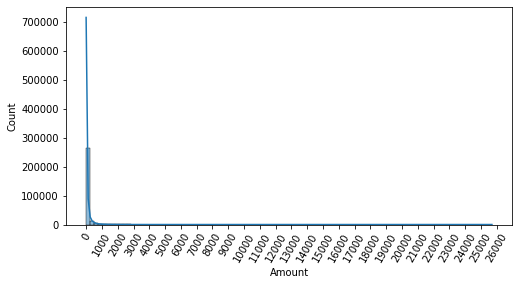

In [26]:
# Amount 피처 분포 확인
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [27]:
# Amount를 표준 정규분포 형태로 변환
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [28]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LGBM 회귀 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LGBM 회귀 예측 성능 ###
오차 행렬
[[85112   183]
 [  126    22]]
정확도: 0.9964, 정밀도: 0.1073, 재현율: 0.1486,    F1: 0.1246, AUC:0.5765


In [29]:
# 로그 변환 수행
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [30]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LGBM 회귀 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LGBM 회귀 예측 성능 ###
오차 행렬
[[85148   147]
 [  147     1]]
정확도: 0.9966, 정밀도: 0.0068, 재현율: 0.0068,    F1: 0.0068, AUC:0.5024


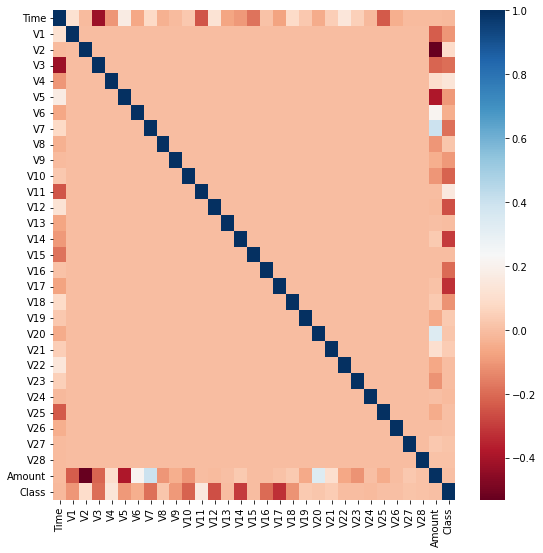

In [31]:
# 이상치 데이터 제거 후 모델 학습/예측/평가
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [32]:
# V14에 대해 이상치 제거
def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [33]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 : ',outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [34]:
# 이상치 삭제 로직을 get_processed_df에 추가
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LGBM 회귀 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LGBM 회귀 예측 성능 ###
오차 행렬
[[85179   116]
 [  117    29]]
정확도: 0.9973, 정밀도: 0.2000, 재현율: 0.1986,    F1: 0.1993, AUC:0.5986


In [35]:
# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터셋 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터셋 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터셋 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터셋 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 0    199020
1    199020
Name: Class, dtype: int64


In [36]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


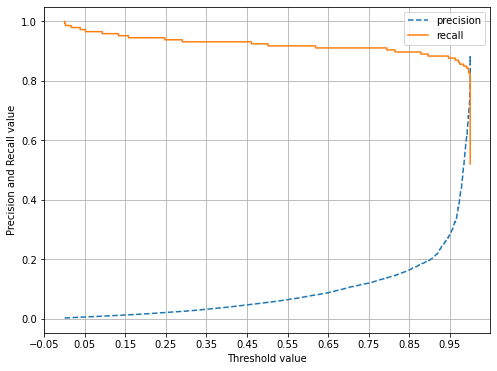

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [1]:
lgbm_clf = LGBMClassifier(n_estimators=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

NameError: ignored

#### 스태킹 앙상블

In [3]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn. metrics import accuracy_score

cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target
X_train,X_test,y_train,y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [4]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [5]:
# 개별 모델 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [7]:
# 개별 모델 예측 데이터셋 생성, 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561 :


In [8]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [9]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도 : 0.9649


In [12]:
# CV 기반 스태킹 모델
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 학습 데이터 반환을 위해 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트 : ',folder_counter, ' 시작 ')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
  return train_fold_pred, test_pred_mean

In [13]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
	 폴드 세트 :  5  시작 
	 폴드 세트 :  6  시작 
RandomForestClassifier model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
	 폴드 세트 :  5  시작 
	 폴드 세트 :  6  시작 
DecisionTreeClassifier model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
	 폴드 세트 :  5  시작 
	 폴드 세트 :  6  시작 
AdaBoostClassifier model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
	 폴드 세트 :  5  시작 
	 폴드 세트 :  6  시작 


In [14]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [15]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
